In [1]:

# import zipfile

# # Specify the zip file path
# zip_file_path = 'Gun_NoGun_Dataset_augmented.zip'

# # Specify the extraction path
# extract_path = '.'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all files
#     zip_ref.extractall(extract_path)

# print(f'Zip file extracted to {extract_path}')

In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.layers import LSTM, GRU
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

2024-09-09 17:58:41.974590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 17:58:41.988024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 17:58:41.992156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 17:58:42.001524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 17:58:42.592463: W tensorflow/compiler/tf2

In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
data_dir =  "Gun_NoGun_Dataset_augmented/"
IMAGE_HEIGHT, IMAGE_WIDTH= 224,224

SEQUENCE_LENGTH =30

In [6]:
class_categories_list = ["Gun", "NoGun"]
model_output_length = len(class_categories_list)

In [7]:
max_pixel_value = 255
def extract_frame(video_path):
  # frames_list = []

  # #print(" the video file path is : {}".format(video_path))
  # videoObj = cv2.VideoCapture(video_path)
  # #print("the video object is: {}".format(videoObj))

  # """ Iterating through Video Frames """
  # while True:

  #   # Reading a frame from the video file
  #   success, image = videoObj.read()
  #   #print("the value of success is: {}".format(success))

  #   if not success:
  #     break

  #   resized_frame = cv2.resize(image, (image_height, image_width))

  #   """Normalize the resized frame by dividing it with 255 so that 
  #   each pixel value then lies between 0 and 1"""

  #   normalized_frame = resized_frame / max_pixel_value
  #   frames_list.append(normalized_frame)

    
  # videoObj.release()


    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
    
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
    
        if not success:
            break
    
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    
    video_reader.release()


    return frames_list



In [8]:
def data_creation():

    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_categories_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(data_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = extract_frame(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = data_creation()

Extracting Data of Class: Gun
Extracting Data of Class: NoGun


In [10]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (516, 30, 224, 224, 3)
the shape of the labels = (516,)


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [13]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (412, 30, 224, 224, 3)
the shape of the labels = (412, 2)


In [14]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (104, 30, 224, 224, 3)
the shape of the labels = (104, 2)


In [15]:
from tensorflow.keras.models import load_model

no_of_channels = 3

# Load the saved model
ResNet_model = load_model('ResNet_Date_Time_2024_08_20__21_12_43___Loss_0.050666701048612595___Accuracy_0.9838435649871826.h5')


# Define the input shape
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, no_of_channels)

# Remove the classification head (last layer)
ResNet_model = Model(inputs=ResNet_model.inputs, outputs=ResNet_model.layers[-5].output)

# Set the new input shape
ResNet_model.build(input_shape)

# Print the updated model summary
ResNet_model.summary()

I0000 00:00:1725919259.386307 2608150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725919259.389458 2608150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725919259.406877 2608150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725919259.409746 2608150 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 7,868,416 (30.02 MB)

 Non-trainable params: 34,758,144 (132.59 MB)

In [16]:
video_input = Input(shape=(SEQUENCE_LENGTH,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [17]:
video_frames_encoded = TimeDistributed(ResNet_model)(video_input)

In [18]:
video_frames_encoded

<KerasTensor shape=(None, 30, 2048), dtype=float32, sparse=False, name=keras_tensor_798>

In [19]:
no_of_classes = 2

In [20]:
video_frames_encoded_sequence = GRU(256)(video_frames_encoded)
#video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)

hidden_layer1 = Dense(1024, activation="relu")(video_frames_encoded_sequence)
#hidden_layer1 = Dropout(0.5)(hidden_layer1)

hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
#hidden_layer2 = Dropout(0.5)(hidden_layer2)

hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
#hidden_layer3 = Dropout(0.25)(hidden_layer3)

hidden_layer4 =  Dense(128, activation="relu")(hidden_layer3)
#hidden_layer4 = Dropout(0.25)(hidden_layer4)

hidden_layer5 =  Dense(64, activation="relu")(hidden_layer4)
#hidden_layer5 = Dropout(0.25)(hidden_layer5)

outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)
model = Model([video_input], outputs)

In [21]:
optimizer = Adam(learning_rate=0.00001)
                  # beta_1=0.9,
                  # beta_2=0.999,
                  # epsilon=1e-08,
                  # weight_decay=0.004)

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 2048)       │    42,626,560 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │     1,771,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,358,146 (173.03 MB)

 Trainable params: 10,600,002 (40.44 MB)

 Non-trainable params: 34,758,144 (132.59 MB)

In [24]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=15)
checkpoint = ModelCheckpoint('ResNet+GRU_best_weights.keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks = [early_stopping_callback, checkpoint]

In [25]:
features_train.shape, labels_train.shape

((412, 30, 224, 224, 3), (412, 2))

In [26]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 100, 
                                   batch_size = 16,
                                   shuffle = True, 
                                   callbacks=[callbacks],
                                   validation_split = 0.2)

Epoch 1/100


2024-09-09 18:03:26.415082: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725919406.477083 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.500902 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.501473 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.502099 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.502659 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.508702 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.509950 2623659 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919406.517216 2623659 gpu_t

 1/21 ━━━━━━━━━━━━━━━━━━━━ 47:48 143s/step - accuracy: 0.4375 - loss: 0.7194

W0000 00:00:1725919408.556537 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.556958 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.557334 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.557710 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.558126 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.558536 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.558965 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.559402 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919408.559826 2623661 gp

20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.4621 - loss: 0.6972

W0000 00:00:1725919424.168373 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.168891 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.169312 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.169755 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.170187 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.170725 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.171241 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.171763 2623609 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919424.172390 2623609 gp

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.4683 - loss: 0.6957

W0000 00:00:1725919425.228548 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.228959 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.229304 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.229648 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.230065 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.230468 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.230884 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.231283 2623605 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725919425.231689 2623605 gp


Epoch 1: val_accuracy improved from -inf to 0.85542, saving model to ResNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.4740 - loss: 0.6943 - val_accuracy: 0.8554 - val_loss: 0.5966
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8446 - loss: 0.5826
Epoch 2: val_accuracy improved from 0.85542 to 0.92771, saving model to ResNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8457 - loss: 0.5815 - val_accuracy: 0.9277 - val_loss: 0.4932
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.8993 - loss: 0.4788
Epoch 3: val_accuracy improved from 0.92771 to 0.96386, saving model to ResNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8989 - loss: 0.4778 - val_accuracy: 0.9639 - val_loss: 0.3906
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9211 - loss: 0.3873
Epoch 4: val_accuracy improved from 0.96386 to 1.00000, saving model to ResNet+GRU_best_w

In [27]:
features_test.shape

(104, 30, 224, 224, 3)

In [28]:
# import datetime as dt

# model2_evaluation_history = model.evaluate(features_test, labels_test)

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()

# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
model_name = "ResNet+GRU.h5"
# Saving your Model
model.save(model_name)


In [29]:
labels_pred_prob = model.predict(features_test)

W0000 00:00:1725921248.737118 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.742042 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.742916 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.743805 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.744869 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.746101 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.747343 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.748751 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921248.750327 2623650 gp

1/4 ━━━━━━━━━━━━━━━━━━━━ 1:56 39s/step

W0000 00:00:1725921249.934606 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.979671 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.980087 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.980500 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.980932 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.981361 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.981747 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.982153 2623661 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921249.982581 2623661 gp

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step  

W0000 00:00:1725921291.167739 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.168225 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.168644 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.169056 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.169504 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.169978 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.170455 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.170992 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.171539 2623650 gp

4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 14s/step


W0000 00:00:1725921291.635710 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.643144 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.643483 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.643821 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.644158 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.644498 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.644833 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.645179 2623650 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725921291.645532 2623650 gp

In [30]:
labels_pred_prob

array([[9.99819100e-01, 1.80979943e-04],
       [3.80803458e-03, 9.96191978e-01],
       [9.99668360e-01, 3.31624615e-04],
       [2.59532622e-04, 9.99740422e-01],
       [1.32374043e-04, 9.99867558e-01],
       [1.61967022e-04, 9.99837995e-01],
       [9.99878645e-01, 1.21335186e-04],
       [9.99316692e-01, 6.83327205e-04],
       [4.03066551e-05, 9.99959707e-01],
       [3.92683893e-01, 6.07316077e-01],
       [9.99755085e-01, 2.44867959e-04],
       [1.24186743e-04, 9.99875784e-01],
       [5.15814245e-05, 9.99948382e-01],
       [3.34887372e-05, 9.99966502e-01],
       [9.99806941e-01, 1.93094384e-04],
       [9.99895453e-01, 1.04592043e-04],
       [2.38690714e-04, 9.99761283e-01],
       [1.14021866e-04, 9.99885917e-01],
       [5.81352178e-05, 9.99941826e-01],
       [9.99903202e-01, 9.67545348e-05],
       [9.99148726e-01, 8.51232151e-04],
       [9.67717290e-01, 3.22827250e-02],
       [3.26038600e-04, 9.99673963e-01],
       [4.95116219e-05, 9.99950528e-01],
       [9.975630

In [31]:
labels_pred = np.argmax(labels_pred_prob, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]))

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, labels_pred)
print(cm)

[[54  0]
 [ 0 50]]


In [33]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        50

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [34]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)

1.0


In [35]:
fpr, tpr, thresholds

(array([0., 0., 0., 1.]),
 array([0.  , 0.02, 1.  , 1.  ]),
 array([         inf, 9.999678e-01, 6.073161e-01, 5.998824e-05],
       dtype=float32))

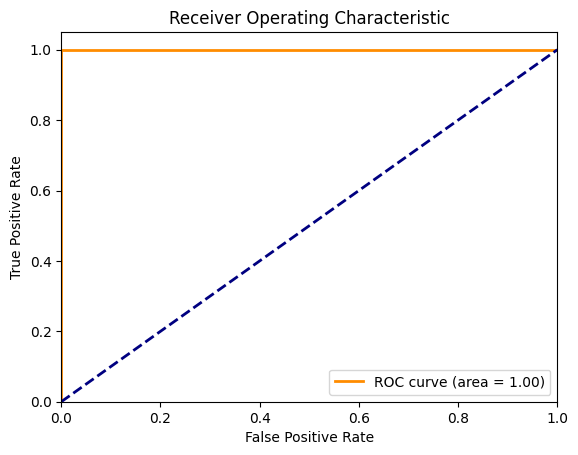

In [36]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()
  plt.show()


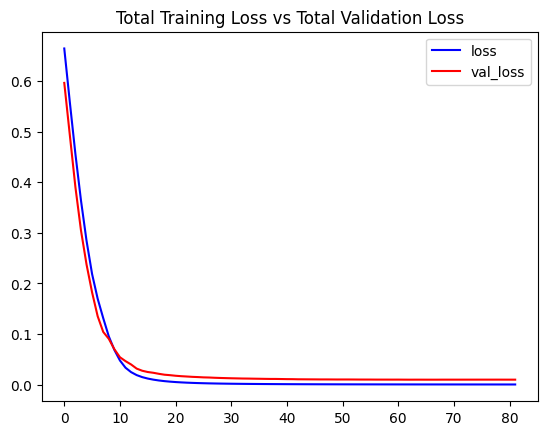

In [38]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

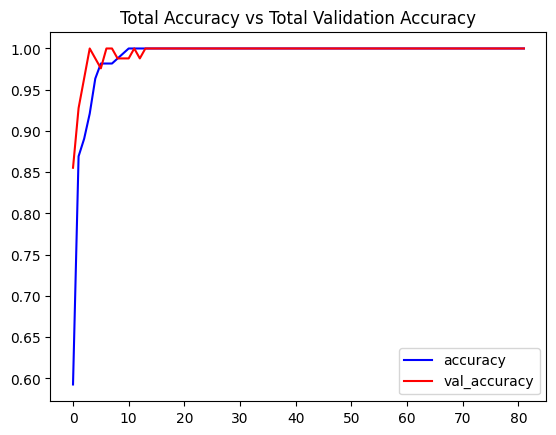

In [39]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')